In [1]:
import pandas as pd
import numpy as np
# import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import xgboost
from xgboost import XGBClassifier
import shap
import seaborn as sns
import yaml

from scripts.check_overlaps import check_overlaps
from make_dataset import make_dataset_censored,  make_dataset_uncensored, repeat_masker, COSMIC_CGC_interactions, TF_binding_site_annotations, create_vep_input, read_vcf, long_range_interactions_results, create_vep_input, read_vcf, clean_and_preprocess

with open("configuration.yaml", "r") as yml_file:
    config = yaml.load(yml_file, yaml.Loader)

c:\ProgramData\anaconda3\envs\ensemble\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\ProgramData\anaconda3\envs\ensemble\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(

In [ ]:
df = pd.read_csv('data/dataset_uncensored.csv')
df = repeat_masker(df, 'train')
df = COSMIC_CGC_interactions(df, 'train')
df = TF_binding_site_annotations(df, 'train')
df = long_range_interactions_results(df, 'train')
df

In [ ]:
df_test = pd.read_csv('data/test_data_final.csv')
df_test = repeat_masker(df_test, 'test')
df_test = COSMIC_CGC_interactions(df_test, 'test')
df_test = TF_binding_site_annotations(df_test, 'test')
df_test = long_range_interactions_results(df_test, 'test')
df_test

Creating the input file for VEP<br>
This file is then given to Ensembl VEP <br>
We used the web version: https://grch37.ensembl.org/Homo_sapiens/Tools/VEP/<br>
Make sure you are using the Grch37 version

In [ ]:
df = create_vep_input(df, "data/VEP/vep_input.vcf")

In [ ]:
test_df_vcf = create_vep_input(df_test, "data/VEP/vep_input_test.vcf")

Reading VEP output<br>
The file generated by Ensembl VEP is downloaded (in .txt format) and used

In [ ]:
df_vep_output = read_vcf('data/VEP/vep_output.txt')
df_vep_output_test = read_vcf('data/VEP/vep_output_test.txt')

Clean and preprocess the data

In [ ]:
df_vep_output = clean_and_preprocess(df_vep_output)
df_vep_output_test = clean_and_preprocess(df_vep_output_test)

In [ ]:
data = df_vep_output.merge(df, left_on=['#Uploaded_variation', 'chr', 'start', 'end'], right_on=['id', 'chr', 'start', 'end'], how='right')
data_test = df_vep_output_test.merge(df_test, left_on=['#Uploaded_variation'], right_on=['id'], how='right')
data.drop(['#Uploaded_variation', 'Location'],inplace = True, axis = 1)
data_test.drop(['#Uploaded_variation', 'Location'],inplace = True, axis = 1)
data_test

In [ ]:
data = data.drop(list(set(data.columns) - set(data_test.columns)), axis = 1)
data_test = data_test.drop(list(set(data_test.columns) - set(data.columns)), axis = 1)

In [ ]:
data = pd.concat([data, data_test])

In [ ]:
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
# data.to_csv('data/final_dataset_combined.csv', index = False)
data = pd.read_csv('data/final_dataset_combined.csv')

In [ ]:
# data.to_csv('data/final_dataset.csv', index = False)
# data_test.to_csv('data/final_dataset_test.csv', index = False)

# XGBoost

In [2]:
data = pd.read_csv('data/final_dataset_combined.csv')

data['TF_binding_site_agg'] = np.logical_or(data['TF_binding_site'], data['TF_binding_site_variant']).astype(int)

data['TF_loss_add'] = data['TF_binding_site_agg'] + data['TF_loss']
data['TF_gain_add'] = data['TF_binding_site_agg'] + data['TF_gain']
data['TF_loss_diff_add'] = data['TF_binding_site_agg'] + data['TF_loss_diff']
data['TF_gain_diff_add'] = data['TF_binding_site_agg'] + data['TF_gain_diff']

data['SpliceAI_pred_DP_AG'] = abs(data['SpliceAI_pred_DP_AG'])
data['SpliceAI_pred_DP_AL'] = abs(data['SpliceAI_pred_DP_AL'])
data['SpliceAI_pred_DP_DG'] = abs(data['SpliceAI_pred_DP_DG'])
data['SpliceAI_pred_DP_DL'] = abs(data['SpliceAI_pred_DP_DL'])

# data_test['TF_binding_site_agg'] = np.logical_or(data_test['TF_binding_site'], data_test['TF_binding_site_variant']).astype(int)

# data_test['TF_loss_add'] = data_test['TF_binding_site_agg'] + data_test['TF_loss']
# data_test['TF_gain_add'] = data_test['TF_binding_site_agg'] + data_test['TF_gain']
# data_test['TF_loss_diff_add'] = data_test['TF_binding_site_agg'] + data_test['TF_loss_diff']
# data_test['TF_gain_diff_add'] = data_test['TF_binding_site_agg'] + data_test['TF_gain_diff']

# data_test['SpliceAI_pred_DP_AG'] = abs(data_test['SpliceAI_pred_DP_AG'])
# data_test['SpliceAI_pred_DP_AL'] = abs(data_test['SpliceAI_pred_DP_AL'])
# data_test['SpliceAI_pred_DP_DG'] = abs(data_test['SpliceAI_pred_DP_DG'])
# data_test['SpliceAI_pred_DP_DL'] = abs(data_test['SpliceAI_pred_DP_DL'])

In [3]:
XGB_PARAMS = {                                            # CODE SOURCE: containers_build\boostdm\config.py
        "objective": "binary:logistic",
        "reg_lambda": 1,
        "random_state": 42,
        "scale_pos_weight": 1,
        "subsample": 0.7,        # fraction of observations to be random samples for each tree
        "reg_alpha": 0,          # L1 regularization term on weight
        "max_delta_step": 0,    # positive value can help make the update step more conservative. generally not used
        "min_child_weight": 1,
        "learning_rate": 1e-03,
        "colsample_bylevel": 1.0,
        "gamma": 0,     # specifies the minimum loss reduction required to make a split. Makes the algorithm conservative
        "colsample_bytree": 1.0,        # fraction of columns to be random samples for each tree
        "booster": "gbtree",
        "max_depth": 4, # Used to control over-fitting as higher depth will allow the model to learn relations very specific to a particular sample
        "silent": 1,
        "seed": 21,
        "eval_metric": 'logloss',
        "early_stopping_rounds": 2000
        # "reg_lambda": 1,  # explore this further

}

# 'ada_score', 'rf_score', 'CADD_PHRED', 'CADD_RAW', 'MODERATE', 'LOW', 'SWISSPROT', 'TREMBL', 'miRNA', 'sense_overlapping', 'misc_RNA'
# 'IG_D_gene', 'IG_J_gene', 'IG_C_gene', 'transcribed_unprocessed_pseudogene', 'non_stop_decay', '3prime_overlapping_ncRNA', 'pseudogene', 'transcribed_processed_pseudogene', 'rNA'
# 'missense_variant', 'synonymous_variant', 'stop_gained', 'stop_lost', 'splice_region_variant', 'inframe_insertion', 'start_lost', 'inframe_deletion', 'frameshift_variant' # not in positive set
# 'splice_acceptor_variant', 'coding_sequence_variant', 'splice_donor_region_variant', 'splice_donor_5th_base_variant' # not in negative set
# open_chromatin_region, 'snRNA', 'snoRNA' # not enough values
# 'STRAND', 'TF_binding_site_variant', 'TF_binding_site', 

COLUMNS_TRAINING = config['COLUMNS_TRAINING']

BIASED_COLUMNS = ['chr', 'ref_x', 'IG_C_gene', 'IG_D_gene', 'IG_J_gene', 'IG_J_pseudogene']

COLUMNS_TRAINING = [x for x in COLUMNS_TRAINING if x not in BIASED_COLUMNS]

COLUMNS_SHAP = [f'my_shap_{x}' for x in COLUMNS_TRAINING]

for col in list(set(COLUMNS_TRAINING) - set(data.columns)):
    data[col] = 0

# for col in list(set(COLUMNS_TRAINING) - set(data_test.columns)):
#     data_test[col] = 0

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

data[COLUMNS_TRAINING] = min_max_scaler.fit_transform(data[COLUMNS_TRAINING])
# data_test[COLUMNS_TRAINING] = min_max_scaler.fit_transform(data_test[COLUMNS_TRAINING])

valset = data[-50:]
data = data[:-50]
valset['driver']

2098    1
2099    1
2100    1
2101    1
2102    1
2103    1
2104    0
2105    1
2106    0
2107    0
2108    0
2109    1
2110    1
2111    1
2112    1
2113    1
2114    1
2115    1
2116    1
2117    1
2118    1
2119    1
2120    1
2121    0
2122    1
2123    1
2124    0
2125    1
2126    0
2127    0
2128    1
2129    0
2130    1
2131    1
2132    1
2133    0
2134    1
2135    0
2136    1
2137    1
2138    0
2139    0
2140    1
2141    1
2142    0
2143    0
2144    0
2145    1
2146    1
2147    1
Name: driver, dtype: int64

# Sweep using WANDB

In [ ]:
from sklearn import metrics
from scipy.stats import ks_2samp
import wandb
from wandb.xgboost import WandbCallback
import os
os.environ["WANDB_API_KEY"] = config['WANDB_API_KEY']

xgboost.set_config(verbosity=0)

In [ ]:
sweep_config = {
  "method" : "grid",
  "parameters" : {
    "learning_rate" :{
      "values": [0.001, 0.005, 0.01]
    },
    "early_stopping_rounds" :{
      "values" : [1000, 2000, 4000]
    },
    "subsample": {    # fraction of observations to be random samples for each tree
      "values": [0.5, 0.7, 0.8, 1.0]
    },
    "max_depth": {
      "values": [4, 6]  
    }, # Used to control over-fitting as higher depth will allow the model to learn relations very specific to a particular sample
  }
}

sweep_id = wandb.sweep(sweep_config, project='thesis', entity='sanabasharat')

def train():
  with wandb.init(job_type="sweep") as run:
    # for i in list_cvs: # for each of the 50 splits
    x_train, x_test, y_train, y_test = train_test_split(data[COLUMNS_TRAINING], data['driver'],
                                                        random_state=104, 
                                                        test_size=0.25, 
                                                        shuffle=True)         # CODE SOURCE: containers_build\boostdm\training.py LIN 44
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=104) # 0.25 x 0.8 = 0.2
    
    bst_params = {
        'objective': 'binary:logistic'
        , 'base_score': y_train.mean()
        , 'gamma': 0
        , 'learning_rate': run.config['learning_rate']
        , 'max_depth': 3
        , 'n_estimators': 20000
        , 'random_state': 42
        , 'early_stopping_rounds': run.config['early_stopping_rounds']
        , 'eval_metric': 'logloss'
        , 'subsample': run.config['subsample']
        , 'max_depth': run.config['max_depth']
        , 'reg_lambda': 1
        , 'random_state': 42
        , 'scale_pos_weight': 1
        , 'silent': 1
        , 'seed': 21
        , 'reg_alpha': 0         # L1 regularization term on weight
        , 'max_delta_step': 0    # positive value can help make the update step more conservative. generally not used
        , 'min_child_weight': 1
        , 'colsample_bylevel': 1.0
        , 'colsample_bytree': 1.0        # fraction of columns to be random samples for each tree
        , 'booster': 'gbtree'
        , 'n_jobs' : 1
        , 'min_child_weight': 1
    }
    # params = XGB_PARAMS.copy()                                          
    # params['n_estimators'] = 20000  # set it high enough to allow "early stopping" events below
    # params['base_score'] = y_train.mean()
    # params['n_jobs'] = 1
    # params['seed'] = seed
    model = XGBClassifier(**bst_params)

    # train with xgboost
    # learning_curve_dict = {}
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
                        callbacks = [
                            xgboost.callback.EvaluationMonitor(rank=0, period=1, show_stdv=False),
                            WandbCallback()
                        ],
                        verbose = 0)

    bst_params['n_estimators'] = model.best_iteration
    model.set_params(**bst_params)
    
    bstr = model.get_booster()

    # Log booster metrics
    run.summary["best_ntree_limit"] = bstr.best_ntree_limit
    
    # Get train and validation predictions
    trnYpreds = model.predict_proba(x_train)[:,1]
    valYpreds = model.predict_proba(x_val)[:,1] 

    # Log additional Train metrics
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, trnYpreds) 
    run.summary['train_ks_stat'] = max(true_positive_rate - false_positive_rate)
    run.summary['train_auc'] = metrics.auc(false_positive_rate, true_positive_rate)
    run.summary['train_log_loss'] = -(y_train * np.log(trnYpreds) + (1-y_train) * np.log(1-trnYpreds)).sum() / len(y_train)

    # Log additional Validation metrics
    ks_stat, ks_pval = ks_2samp(valYpreds[y_val==1], valYpreds[y_val==0])
    run.summary["val_ks_2samp"] = ks_stat
    run.summary["val_ks_pval"] = ks_pval
    run.summary["val_auc"] = metrics.roc_auc_score(y_val, valYpreds)
    run.summary["val_acc_0.5"] = metrics.accuracy_score(y_val, np.where(valYpreds >= 0.5, 1, 0))
    run.summary["val_log_loss"] = -(y_val * np.log(valYpreds) + (1-y_val) * np.log(1-valYpreds)).sum() / len(y_val)

In [ ]:
# count = 10 # number of runs to execute
wandb.agent(sweep_id, function=train)

# Simple run

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data[COLUMNS_TRAINING], data['driver'],
                                                    random_state=104, 
                                                    test_size=0.25, 
                                                    shuffle=True)         # CODE SOURCE: containers_build\boostdm\training.py LIN 44
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=104) # 0.25 x 0.8 = 0.2

params = XGB_PARAMS.copy()                                          
params['n_estimators'] = 20000  # set it high enough to allow "early stopping" events below
params['base_score'] = y_train.mean()
params['silent'] = True
# params['n_jobs'] = 1
params['seed'] = 104
model = XGBClassifier(**params)

# train with xgboost
# learning_curve_dict = {}
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
                    callbacks = [
                        xgboost.callback.EvaluationMonitor(rank=0, period=1, show_stdv=False)
                    ],
                    verbose = 0)

params['n_estimators'] = model.best_iteration
model.set_params(**params)

In [ ]:
model.

In [ ]:
y_test_data = data_test[COLUMNS_TRAINING]
y_test_data

In [ ]:
model

In [15]:
y_pred = model.predict(x_test)
y_pred

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,

In [ ]:
y_test

In [16]:
score = accuracy_score(y_test, y_pred)
print('Accuracy: %.3f' % score)

Accuracy: 0.964


In [17]:
log_loss(y_pred, y_test)

1.3044369797966209

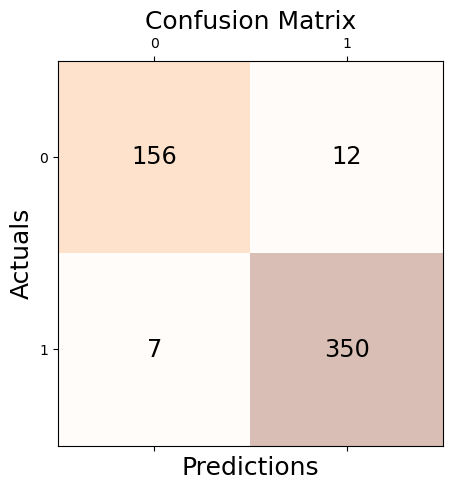

In [19]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

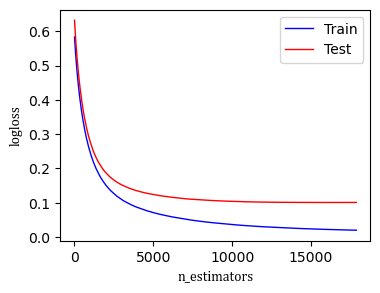

In [20]:
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train', color='blue', linewidth = '1')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test', color='red', linewidth = '1')
ax.legend()
plt.ylabel('logloss',{'fontname':'Cambria'})
plt.xlabel('n_estimators',{'fontname':'Cambria'})
# plt.title('XGBoost logloss', {'fontname':'Cambria'})
plt.show()

In [21]:
yhat = model.predict(x_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)

Accuracy: 0.964


In [22]:
log_loss(yhat, y_test)

1.3044369797966209

In [23]:
from random import seed
from random import randrange
 
# zero rule algorithm for classification
def zero_rule_algorithm_classification(train, test):
 output_values = [row[-1] for row in train]
 prediction = max(set(output_values), key=output_values.count)
 predicted = [prediction for i in range(len(test))]
 return predicted

train = x_train
train['driver'] = y_train
test = x_test
test['driver'] = y_test
seed(1)
# train = [['0'], ['0'], ['0'], ['0'], ['1'], ['1']]
# test = [[None], [None], [None], [None]]
predictions = zero_rule_algorithm_classification(train, test)
print(predictions)

['t', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't',

In [24]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
print('precision: ', precision_score(y_test, yhat))
print('recall: ' , recall_score(y_test, yhat))
print('f1_score: ', f1_score(y_test, yhat))
print('roc_auc_score: ', roc_auc_score(y_test, yhat))

precision:  0.9668508287292817
recall:  0.9803921568627451
f1_score:  0.9735744089012517
roc_auc_score:  0.9544817927170869


In [ ]:
valsetpred = model.predict(valset[COLUMNS_TRAINING])
print(valset['driver'])
print(valsetpred)

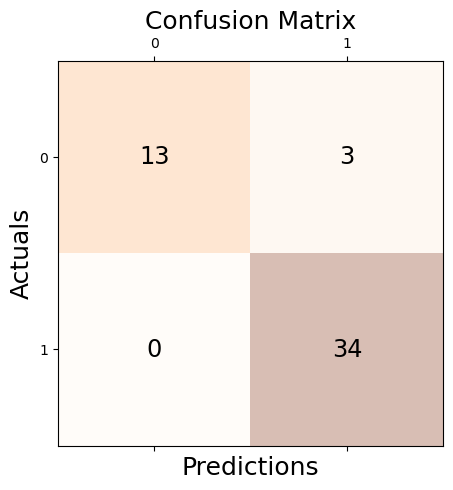

In [27]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=valset['driver'], y_pred=valsetpred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [29]:
valset['data_source']

2098    Rheinbay et al 2020
2099    Rheinbay et al 2020
2100                   TCGA
2101    Rheinbay et al 2020
2102    Rheinbay et al 2020
2103            Dr.Nod 2023
2104                 COSMIC
2105    Rheinbay et al 2020
2106                 COSMIC
2107                 COSMIC
2108                 COSMIC
2109    Rheinbay et al 2020
2110    Rheinbay et al 2020
2111    Rheinbay et al 2020
2112                   ICGC
2113    Rheinbay et al 2020
2114    Rheinbay et al 2020
2115                   TCGA
2116                   ICGC
2117    Rheinbay et al 2020
2118            Dr.Nod 2023
2119                   ICGC
2120                   ICGC
2121                 COSMIC
2122    Rheinbay et al 2020
2123            Dr.Nod 2023
2124                 COSMIC
2125    Rheinbay et al 2020
2126                 COSMIC
2127                 COSMIC
2128                   ICGC
2129                 COSMIC
2130                   ICGC
2131            Dr.Nod 2023
2132                   ICGC
2133                

In [49]:
import joblib
filename = 'trained_model_combined.sav'
# joblib.dump(model, filename)
# model.to_pickle('trained_model.')
 
# some time later...
 
# load the model from disk
model = joblib.load(filename)
# result = loaded_model.score(x_test, y_test)
# print(result)

In [50]:
yhat = model.predict(valset[COLUMNS_TRAINING])
score = accuracy_score(valset['driver'], yhat)
print('Accuracy: %.3f' % score)

Accuracy: 0.940


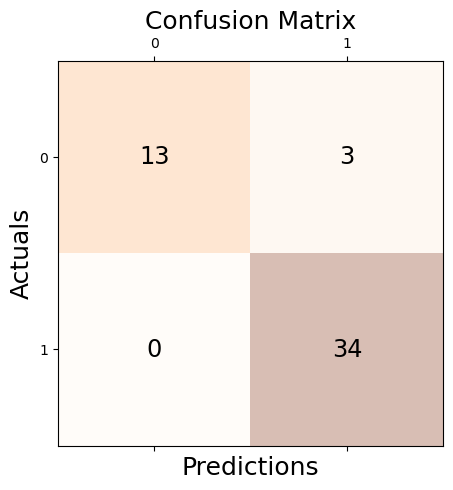

In [51]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=valset['driver'], y_pred=yhat)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

SHAP Explainer

In [52]:
# SHAP attribution
x_data = data[COLUMNS_TRAINING]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)
# shap_values = np.mean(shap_bootstrap, axis=0)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [53]:
for c in COLUMNS_SHAP:
    data[c] = np.nan
data.loc[data.index, COLUMNS_SHAP] = shap_values

In [ ]:
x_data.columns

In [ ]:
x_data[['splice_acceptor_variant', 'splice_donor_variant', 'promoter', 'downstream_gene_variant', 'regulatory_region_variant']]#.describe()
# x_data.columns.get_loc('splice_acceptor_variant')
# x_data.columns.get_loc('splice_donor_variant')
# x_data.columns.get_loc('LOEUF')
data['driver'].value_counts()

In [ ]:
shap_values[:,[60, 24, 38, 17, 23]]

In [ ]:
# shap.summary_plot(shap_values[:,2:5], x_data.iloc[:, 2:5], plot_size = 0.25)  # protein product
# shap.summary_plot(shap_values[:,6:14], x_data.iloc[:, 6:14], plot_size = 0.25)  # splice ai
# shap.summary_plot(shap_values[:,0:2], x_data.iloc[:, 0:2], plot_size = 0.25) #ada score rf score
shap.summary_plot(shap_values[:,44:48], x_data.iloc[:, 44:48], plot_size = 0.25)  # interactions
# shap.summary_plot(shap_values[:,53:60], x_data.iloc[:, 53:60], plot_size = 0.25) # cosmic genes
# shap.summary_plot(shap_values[:,48:53], x_data.iloc[:, 48:53], plot_size = 0.25) #repeat masker
# shap.summary_plot(shap_values[:,73:77], x_data.iloc[:, 73:77], plot_size = 0.25)  # tf
# shap.summary_plot(shap_values[:,5:6], x_data.iloc[:, 5:6], plot_size = 0.25)  # loeuf
# shap.summary_plot(shap_values[:,[60, 24, 38, 17, 23]], x_data.iloc[:, [60, 24, 38, 17, 23]], plot_size = 0.25) # the rest

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


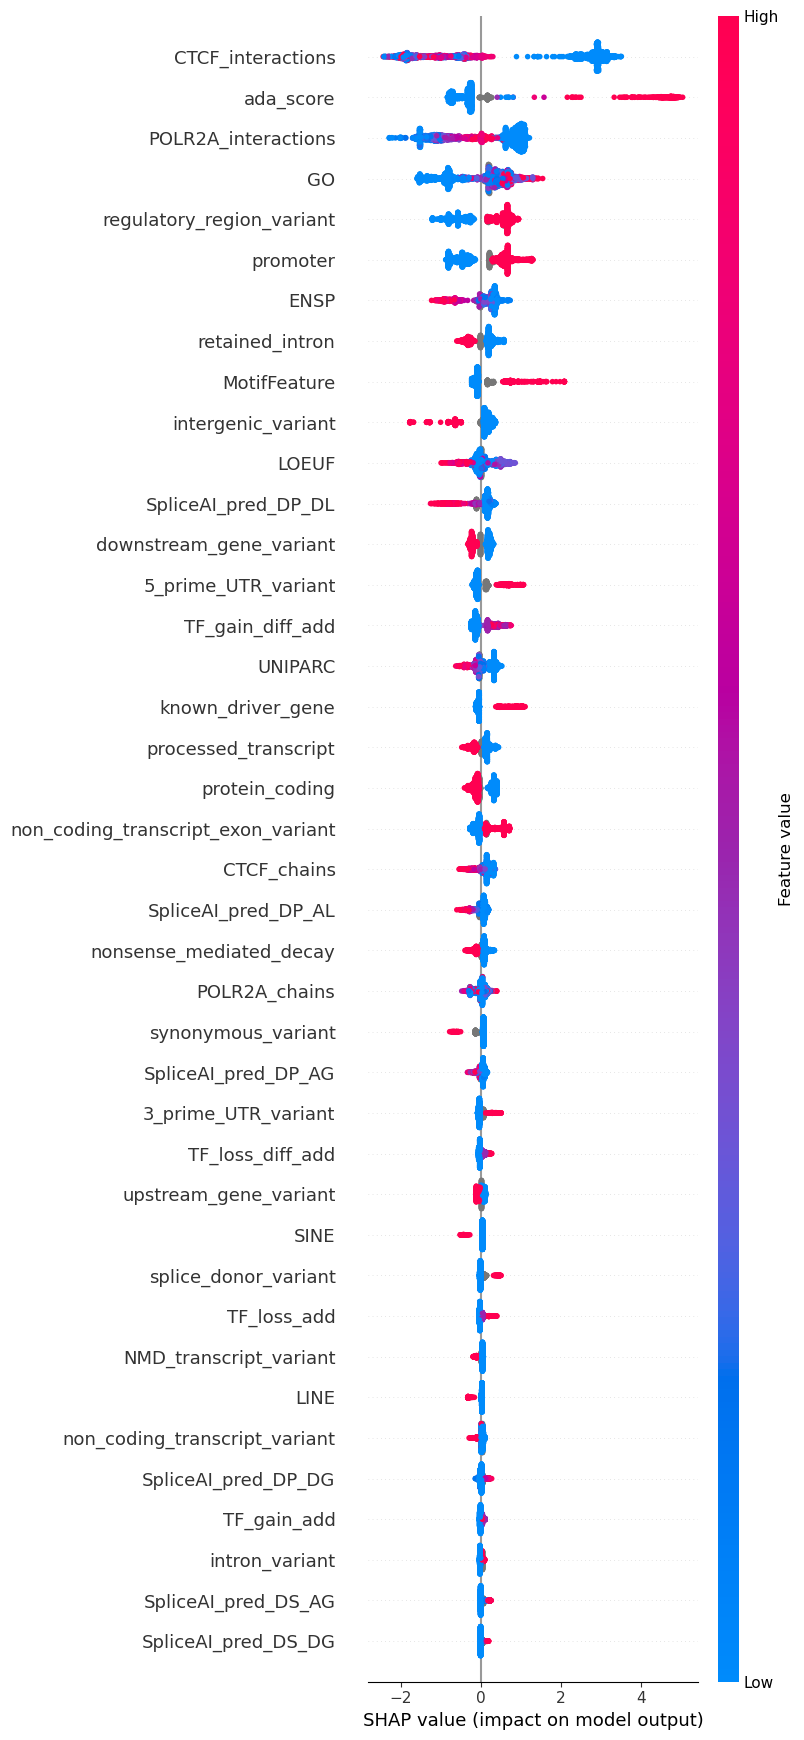

In [54]:
shap.summary_plot(shap_values, x_data, max_display=40)

In [ ]:
shap.dependence_plot("CTCF_interactions", shap_values, x_data, interaction_index="CTCF_chains")

In [ ]:
# shap.plots.heatmap(shap_values)
shap_values_explaination = shap.Explanation(shap_values, feature_names=data[COLUMNS_TRAINING].columns.tolist()) 
shap.plots.heatmap(shap_values_explaination, max_display=12)

In [ ]:
x_data = data[COLUMNS_TRAINING]
explainer = shap.TreeExplainer(model) # grabbing the first model
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[101:200], x_data[101:200])

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=data[COLUMNS_TRAINING].columns)
feat_importances.nlargest(40).plot(kind='barh')

In [ ]:
import pandas as pd
import numpy as np
import os
from anytree import Node, RenderTree, AsciiStyle, LevelGroupOrderIter, LevelOrderGroupIter, search
from intervaltree import Interval, IntervalTree
import multiprocessing
import time

def read_dataset():
    df_pos = pd.read_csv('artifacts/df_grch38.bed', sep='\t', header=None)
    df_pos.columns = ['chr', 'start', 'end']

    orig = pd.read_csv('ICGC_TCGA_noncoding_data.csv')
    df_pos['pos_37'] = orig['pos']
    df_pos.drop_duplicates(keep='first', inplace=True)

    df_neg = pd.read_csv('negdf_grch38.bed', sep='\t', header=None)
    df_neg.columns = ['chr', 'start', 'end', 'old_pos', 'bed_format']
    df_neg['chr'] = df_neg['chr'].apply(lambda x: x.replace('chr', ''))
    df_neg['chr_old'] = df_neg['old_pos'].str.split(':').str[0].str.replace('chr', '')
    df_neg['start_old'] = df_neg['old_pos'].str.split(':').str[1].str.split('-').str[1]
    df_neg['end_old'] = df_neg['old_pos'].str.split(':').str[1].str.split('-').str[0]
    df_neg['start_old'] = pd.to_numeric(df_neg['start_old'])
    df_neg['end_old'] = pd.to_numeric(df_neg['end_old'])
    metadata = pd.read_csv(r'C:\Users\Sana\Downloads\ChiaPET\metadata.tsv', sep='\t')

    df_pos = df_pos[['chr', 'start', 'end', 'pos_37']]
    df_pos['driver'] = 1
    df_pos.drop_duplicates(keep='first', inplace=True)

    df_neg = df_neg[['chr', 'start', 'end', 'start_old']]
    df_neg['driver'] = 0
    df_neg.rename(columns = {'start_old': 'pos_37'}, inplace = True)
    df_neg.drop_duplicates(keep='first', inplace=True)

    df = pd.concat([df_pos, df_neg])
    return df                              # final dataset including negative and positive set

In [ ]:
df = read_dataset()
df.sort_values('chr', inplace=True)
df.reset_index(drop = True, inplace = True)
df['CTCF_interactions'] = 0
df['CTCF_chains'] = 0
df['POLR2A_interactions'] = 0
df['POLR2A_chains'] = 0

chr = '17'
mutation = 50862973
all_files = ['ENCFF271VMZ.bedpe']
for file in all_files:
    print(file)
    cp = pd.read_csv('C:/Users/Sana/Downloads/ChiaPET/' + file, sep = '\t',  header = None)
    cp.columns = ['chr_A', 'start_A', 'end_A', 'chr_B', 'start_B', 'end_B', 'score']
    cp['chr_A'] = cp['chr_A'].map(lambda x: x.replace('chr', ''))
    cp['chr_B'] = cp['chr_B'].map(lambda x: x.replace('chr', ''))
    
    cp = cp[cp['chr_A'] == chr]
    interactions_tree = IntervalTree()

    for index, row in cp.iterrows():
        interactions_tree.add(Interval(row['start_A'], row['end_A'], tuple([row['chr_A'], row['start_B'], row['end_B']]))) # fotwards interaction
        interactions_tree.add(Interval(row['start_B'], row['end_B'], tuple([row['chr_A'], row['start_A'], row['end_A']]))) # backwards interaction
        
    # df_tree = []
    
    # save_tree = interactions_tree.copy()
    # for index, row in df.iterrows():          # this is to make an AnyTree for each mutation in the dataset, and store them all in a list
    #     df_tree.append(Node(name = row['chr'] + ':' + str(row['start']) + '-' + str(row['end']), chr = row['chr'], start = row['start'], end = row['end'], checked = 0))

    # #checking just one mutation
    # df_tree = Node(name = 'artificial', chr = '17', start = 59210051, end = 59210052, checked = 0)
    df_tree = Node(name = 'artificial', checked = 0)
    # df_tree = Node(name = 'artificial', chr = '3', start = 5, end = 6, checked = 0)     # checking just one artificial mutation

    found_overlap = False
    if len(interactions_tree.at(mutation)) > 0:
        found_overlap = True
        for i in interactions_tree.at(mutation):
            Node(Interval(i.data[1], i.data[2]), checked = 0, parent = df_tree)
            interactions_tree.remove(i)
            inv = Interval(i.data[1], i.data[2], tuple([i.data[0], i.begin, i.end]))
            interactions_tree.remove(inv)

    interactions = 0
    chains = 0
    if found_overlap:
        children_left = True
        while children_left is True:
            children_left = False
            for node in df_tree.leaves:
                if node.checked == 0:
                    node.checked = 1
                    found_list = list(interactions_tree.overlap(node.name))
                    for found_node in found_list:
                        print("FOUND: ", found_node)
                        children_left = True
                        Node(name = Interval(found_node.data[1], found_node.data[2]), checked = 0, parent = node)
                        print("REMOVING: ", found_node)
                        try:
                            interactions_tree.remove(found_node)# only remove that node which satisfies both conditions of similarity
                        except:
                            pass
                        try:
                            interactions_tree.remove(Interval(found_node.data[1], found_node.data[2], tuple([found_node.data[0], found_node.begin, found_node.end])))
                        except:
                            pass

        interactions = len(set([k.name for k in df_tree.descendants]))
        chains = sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree, filter_=lambda node: node.is_leaf and not node.is_root) if leaf])


    # if metadata[metadata['File accession'] == file.replace('.bedpe', '')]['Experiment target'].iloc[0].replace('-human', '') == 'CTCF':
    #     print('CTCF_interactions', len(df_tree.descendants))
    #     print('CTCF_chains', sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree, filter_=lambda node: node.is_leaf and not node.is_root) if leaf]))
    #     # for index, row in df.iterrows():
    #     #     df.at[index, 'CTCF_interactions'] = row['CTCF_interactions'] + len(df_tree[index].descendants)
    #     #     df.at[index, 'CTCF_chains'] = row['CTCF_chains'] + sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree[index], filter_=lambda node: node.is_leaf and not node.is_root) if leaf])
    # else:
    #     print('POLR2A_interactions', len(df_tree.descendants))
    #     print('POLR2A_chains', sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree, filter_=lambda node: node.is_leaf and not node.is_root) if leaf]))
        # for index, row in df.iterrows():
        #     df.at[index, 'POLR2A_interactions'] = row['POLR2A_interactions'] + len(df_tree[index].descendants)
        #     df.at[index, 'POLR2A_chains'] = row['POLR2A_chains'] + sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree[index], filter_=lambda node: node.is_leaf and not node.is_root) if leaf])      

In [ ]:
interactions

In [ ]:
chains

In [ ]:
import pickle
with open('files_to_keep', 'wb') as f:
    pickle.dump(files_to_keep, f)

In [ ]:
len(files_to_keep)

In [ ]:
all_files = os.listdir(r"C:/Users/Sana/Downloads/ChiaPET")
all_files.remove('files.txt')
all_files.remove('metadata.tsv')
all_files = [item for item in all_files if item in files_to_keep]

In [ ]:
files_to_keep = [item + '.bedpe' for item in files_to_keep]

In [ ]:
len([item for item in all_files if item in files_to_keep])